# Customer Churn Analysis

This notebook presents a complete churn analysis case study using a telecom customer dataset. 
The objective is to understand why customers churn, predict churn risk, and recommend actionable business strategies.

### What is Churn?
Customer churn refers to customers who stop using a company's service within a given period.  
In this telecom context, churn is defined as customers who terminated their subscription.

### Why is Churn Important?
    - Acquiring new customers is more expensive than retaining existing ones
    - High churn indicates poor customer experience or pricing issues
    - Reducing churn directly improves revenue and profitability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## Data Loading

In [2]:
set = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn 2.csv")

In [3]:
set.shape

(7043, 21)

In [4]:
set.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Cleaning & Preparation

In [5]:
data = set.copy()

In [6]:
set.isnull().sum()   # Check missing values

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [7]:
set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
set['TotalCharges'] = pd.to_numeric(set['TotalCharges'], errors='coerce')      # Convert TotalCharges to numeric

In [9]:
telecom = set[set['tenure'] > 0]

In [10]:
telecom.shape

(7032, 21)

In [11]:
telecom.to_csv('Telecom_Customer_Churn_Analysis.csv')

In [12]:
telecom['Churn'].value_counts()          ### Validate Target Variable

Churn
No     5163
Yes    1869
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

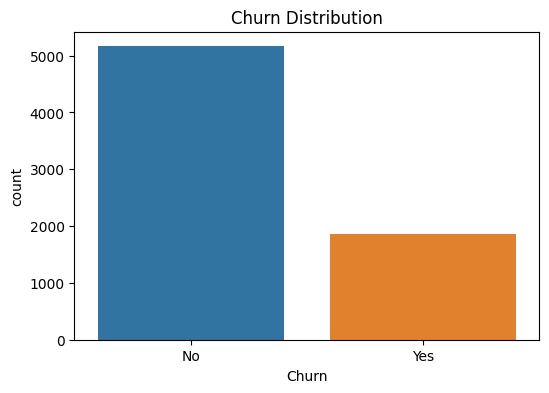

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=telecom)
plt.title("Churn Distribution")
plt.show()

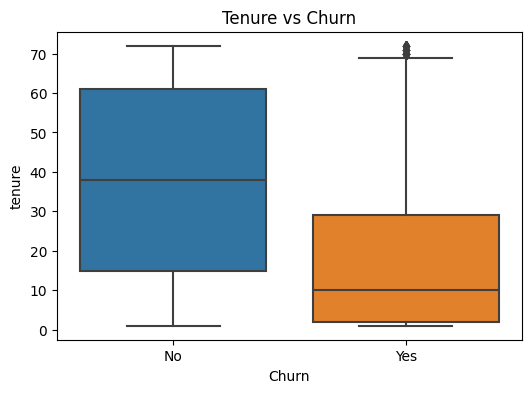

In [14]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='tenure', data=telecom)
plt.title("Tenure vs Churn")
plt.show()

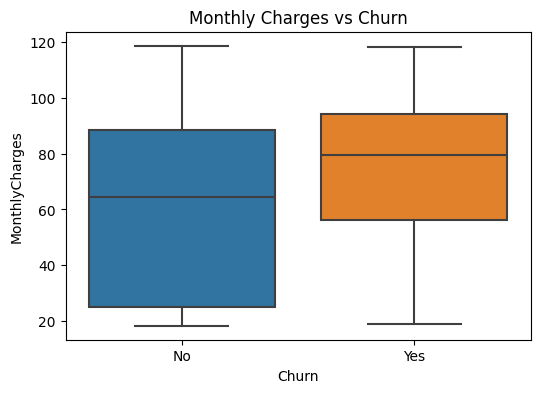

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=telecom)
plt.title("Monthly Charges vs Churn")
plt.show()

### Key EDA Insights
- Churned customers typically have shorter tenure
- Higher monthly charges increase churn probability
- New customers are at the highest risk

## Feature Engineering

In [16]:
telecom = telecom.copy()
telecom.loc[:, 'Churn'] = telecom['Churn'].map({'Yes': 1, 'No': 0})        # Binary encoding

In [17]:
cat_cols = telecom.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    telecom[col] = le.fit_transform(telecom[col])            # Encode categorical variables

In [18]:
telecom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5365,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,3953,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2558,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,5524,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,6500,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


## Churn Modeling

In [19]:
X = telecom.drop(['Churn', 'customerID'], axis=1)
y = telecom['Churn']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [22]:
X_test = scaler.transform(X_test)

### Logistic Regression Model

In [23]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

In [25]:
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1291
           1       0.64      0.57      0.61       467

    accuracy                           0.80      1758
   macro avg       0.75      0.73      0.74      1758
weighted avg       0.80      0.80      0.80      1758

ROC-AUC: 0.8376215174399607


### Random Forest Model

In [26]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [27]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

In [28]:
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1291
           1       0.63      0.48      0.55       467

    accuracy                           0.79      1758
   macro avg       0.73      0.69      0.70      1758
weighted avg       0.78      0.79      0.78      1758

ROC-AUC: 0.8167978941676605


## Postdictive Analysis

In [29]:
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_rf,
    'Probability': y_prob_rf
})

In [30]:
results.head()

,Actual,Predicted,Probability
945,1,1,0.685
504,0,0,0.045
4856,1,0,0.275
4150,0,1,0.815
5884,1,0,0.165


### Model Performance Review

## Business Recommendations

#### Recommended Actions

#### Target Segment

## Conclusion
This churn analysis demonstrates how data-driven insights can help organizations predict churn and take proactive retention actions.